# Install libraries

In [ ]:
!pip install -r requirements.txt

In [ ]:
# https://github.com/teddysum/korean_ABSA_baseline/blob/0d47e3eef31419a2d31d859da2dfba4f9df75531/src/sentiment_analysis.py#L532-L630

def evaluation_f1(true_data, pred_data):

    true_data_list = true_data
    pred_data_list = pred_data

    ce_eval = {
        'TP': 0,
        'FP': 0,
        'FN': 0,
        'TN': 0
    }

    pipeline_eval = {
        'TP': 0,
        'FP': 0,
        'FN': 0,
        'TN': 0
    }

    for i in range(len(true_data_list)):

        # TP, FN checking
        is_ce_found = False
        is_pipeline_found = False
        for y_ano  in true_data_list[i]['annotation']:
            y_category = y_ano[0]
            y_polarity = y_ano[2]

            for p_ano in pred_data_list[i]['annotation']:
                p_category = p_ano[0]
                p_polarity = p_ano[1]

                if y_category == p_category:
                    is_ce_found = True
                    if y_polarity == p_polarity:
                        is_pipeline_found = True

                    break

            if is_ce_found is True:
                ce_eval['TP'] += 1
            else:
                ce_eval['FN'] += 1

            if is_pipeline_found is True:
                pipeline_eval['TP'] += 1
            else:
                pipeline_eval['FN'] += 1

            is_ce_found = False
            is_pipeline_found = False

        # FP checking
        for p_ano in pred_data_list[i]['annotation']:
            p_category = p_ano[0]
            p_polarity = p_ano[1]

            for y_ano  in true_data_list[i]['annotation']:
                y_category = y_ano[0]
                y_polarity = y_ano[2]

                if y_category == p_category:
                    is_ce_found = True
                    if y_polarity == p_polarity:
                        is_pipeline_found = True

                    break

            if is_ce_found is False:
                ce_eval['FP'] += 1

            if is_pipeline_found is False:
                pipeline_eval['FP'] += 1
            
            is_ce_found = False
            is_pipeline_found = False

    ce_precision = ce_eval['TP']/(ce_eval['TP']+ce_eval['FP'])
    ce_recall = ce_eval['TP']/(ce_eval['TP']+ce_eval['FN'])

    ce_result = {
        'Precision': ce_precision,
        'Recall': ce_recall,
        'F1': 2*ce_recall*ce_precision/(ce_recall+ce_precision)
    }

    pipeline_precision = pipeline_eval['TP']/(pipeline_eval['TP']+pipeline_eval['FP'])
    pipeline_recall = pipeline_eval['TP']/(pipeline_eval['TP']+pipeline_eval['FN'])

    pipeline_result = {
        'Precision': pipeline_precision,
        'Recall': pipeline_recall,
        'F1': 2*pipeline_recall*pipeline_precision/(pipeline_recall+pipeline_precision)
    }

    return {
        'category extraction result': ce_result,
        'entire pipeline result': pipeline_result
    }

# Load libraries

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import os, sys
import re
import time
import json
import random
import pickle
import numpy as np
import pandas as pd
from tqdm import tqdm
from copy import deepcopy
import matplotlib.pyplot as plt

from sklearn.metrics import f1_score

import torch
import torch.nn.functional as F
from torch.utils.data import (
    TensorDataset, DataLoader, RandomSampler, SequentialSampler, WeightedRandomSampler
)
from transformers import (
    AdamW, get_linear_schedule_with_warmup,
    ElectraTokenizerFast, ElectraForSequenceClassification, ElectraForTokenClassification,
    BertTokenizerFast, BertForSequenceClassification
)

os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [ ]:
# device = 'cpu'
device = 'cuda'
seed = 1235
batch_size = 4
learning_rate = 1e-5
warmup_proportion = 0.1
epochs = 10
warmup_steps = 1000
# max_len= 256

gradient_accumulation_steps = 4
num_train_epochs = epochs

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

# Load data

## data

In [ ]:
train = []
with open('data/nikluge-sa-2022-train.jsonl', 'r') as file:
    for line in file.readlines():
        train.append(json.loads(line))

train[34]= {'id': 'nikluge-sa-2022-train-00035',
 'sentence_form': '물론 쥐시장 가면 천원짜리도 많겠지만 가격대비 면이 좋네.',
 'annotation': [['본품#품질', ['면', 26, 27], 'positive']]}
train[2529]= {'id': 'nikluge-sa-2022-train-02530',
 'sentence_form': '피부가 건조해서 거칠어지신 분들... 피부 속과 겉 모두 건조하신 분들은 #수분집중 라인을 선택해주시면 되겠습니당!',
 'annotation': [['제품 전체#일반', [' #수분집중 라인', 41, 49], 'positive']]}

val = []
with open('data/nikluge-sa-2022-dev.jsonl', 'r') as file:
    for line in file.readlines():
        val.append(json.loads(line))

val[2609] = {'id': 'nikluge-sa-2022-dev-02610',
 'sentence_form': '매일 아침저녁으로 열심히 바르고 있는 크림이에요 🙆🏻💞',
 'annotation': [['제품 전체#일반', ['크림', 21, 23], 'positive']]}

In [ ]:
test = []
with open('data/nikluge-sa-2022-test.jsonl', 'r') as file:
    for line in file.readlines():
        test.append(json.loads(line))

In [ ]:
entity_property_pair = [
    '본품#가격', '본품#다양성', '본품#디자인', '본품#인지도', '본품#일반', '본품#편의성', '본품#품질', 
    '브랜드#가격', '브랜드#디자인', '브랜드#인지도', '브랜드#일반', '브랜드#품질', 
    '제품 전체#가격', '제품 전체#다양성', '제품 전체#디자인', '제품 전체#인지도', '제품 전체#일반', '제품 전체#편의성', '제품 전체#품질', 
    '패키지/구성품#가격', '패키지/구성품#다양성', '패키지/구성품#디자인', '패키지/구성품#일반', '패키지/구성품#편의성', '패키지/구성품#품질'
]

entity_property_pair.sort()

entity_name_to_id = {entity_property_pair[i]: i for i in range( len(entity_property_pair) )}
entity_id_to_name = {v:k for k, v in entity_name_to_id.items()}

label_id_to_name = ['True', 'False']
label_name_to_id = {label_id_to_name[i]: i for i in range(len(label_id_to_name))}

polarity_id_to_name = ['positive', 'negative', 'neutral']
polarity_name_to_id = {polarity_id_to_name[i]: i for i in range(len(polarity_id_to_name))}

In [ ]:
from copy import deepcopy
def convert(array: np.array, data: list):
    iter = array.shape[0]
    if iter != len(data):
        raise ValueError
    result = deepcopy(data)
    for i in range(iter):
        ind = np.where(array[i]==1)[0]
        result[i]['annotation'] = [[ entity_id_to_name[k], 'positive'] for k in ind]
    return result

# Set model

## electra

In [ ]:
tokenizer = ElectraTokenizerFast.from_pretrained("kykim/electra-kor-base")
model = ElectraForSequenceClassification.from_pretrained("kykim/electra-kor-base", num_labels = 1)

In [ ]:
state_dict = torch.load('model/electra_epoch_03_20221011.bin', map_location = 'cpu')
# state_dict = torch.load('model/electra_epoch_06_20221005.bin', map_location = 'cpu')
model.load_state_dict(state_dict)
model.to(device)
print(device)

cuda


### Add special tokens - categories

In [ ]:
entity_pre = set(map(lambda x: x[0], map(lambda x: x.rsplit('#', 2), entity_property_pair)))
entity_post = set(map(lambda x: x[1], map(lambda x: x.rsplit('#', 2), entity_property_pair)))
entity_pre = ['['+e+']' for e in entity_pre]
entity_pre.sort()
entity_post = ['['+e+']' for e in entity_post]
entity_post.sort()

special_tokens = entity_pre + entity_post
# tokenizer.add_tokens(special_tokens)
tokenizer.add_special_tokens(dict(zip(['additional_special_tokens'], [special_tokens])) )

11

In [ ]:
tokenizer.get_special_tokens_mask([2,3,4,66,42000, 42010], already_has_special_tokens=True)

[1, 1, 1, 0, 1, 1]

In [ ]:
special_tokens == tokenizer.convert_ids_to_tokens(range(42000, 42011))

True

In [ ]:
tokenizer.convert_tokens_to_ids('[품질]')

42010

In [ ]:
model.resize_token_embeddings(len(tokenizer))

Embedding(42011, 768)

In [ ]:
wt = model.electra.embeddings.word_embeddings.weight.clone()
for st in special_tokens:
    i = tokenizer.vocab[st]
    st = re.sub(r'\W', ' ', st).strip()
    tok_st = tokenizer.encode(st, add_special_tokens=False)
    w = wt[tok_st].clone() if len(tok_st) == 1 else wt[tok_st].mean(0)
    wt[i] = w

In [ ]:
model.electra.embeddings.word_embeddings.weight = torch.nn.Parameter(wt)

In [ ]:
state_dict = torch.load('model/electra.bin', map_location = 'cpu')
model.load_state_dict(state_dict)
model.to(device)
print(device)

cuda


# data loader

## ACD

### normal

In [ ]:
def get_devset(batch, train, max_len = 512):
    train_docs = [t['sentence_form'] for t in train]
    docs = [train_docs[b] for b in batch]
    train_batch = [train[b] for b in batch]

    result = []
    labels = []
    
    for idx, t in enumerate(train_batch):
        lab = torch.zeros(max_len, dtype=torch.long)
        cat_ids = [0] * len(entity_name_to_id)
        for a in t['annotation']:
            cat_ids[entity_name_to_id[a[0]]] = 1
        
        sents = [t['sentence_form']] * len(entity_name_to_id)
        cats = list(entity_name_to_id.keys())
        tokenized = tokenizer(sents, cats, padding='max_length', truncation=True, max_length=max_len)
        tokenized = [v for k, v in tokenized.items()]
        result.append(tokenized)
        labels.append(cat_ids)

    result = torch.tensor(result, dtype=torch.long).transpose(1,2)
    labels = torch.tensor(labels, dtype=torch.long)
    print(result.shape, labels.shape)
    return result, labels


In [ ]:
# label first

def get_devset(batch, train, max_len = 512):
    train_docs = [t['sentence_form'] for t in train]
    docs = [train_docs[b] for b in batch]
    train_batch = [train[b] for b in batch]

    result = []
    labels = []
    
    for idx, t in enumerate(train_batch):
        lab = torch.zeros(max_len, dtype=torch.long)
        cat_ids = [0] * len(entity_name_to_id)
        for a in t['annotation']:
            cat_ids[entity_name_to_id[a[0]]] = 1
        
        sents = [t['sentence_form']] * len(entity_name_to_id)
        cats = list(entity_name_to_id.keys())
        tokenized = tokenizer(cats, sents, padding='max_length', truncation=True, max_length=max_len)
        tokenized = [v for k, v in tokenized.items()]
        result.append(tokenized)
        labels.append(cat_ids)

    result = torch.tensor(result, dtype=torch.long).transpose(1,2)
    labels = torch.tensor(labels, dtype=torch.long)
    print(result.shape, labels.shape)
    return result, labels


In [ ]:
from copy import deepcopy

def get_trainset(batch, train, max_len = 512, masked = -100, mask_all_samples = False, null_anno = 'all_tokens'):
    train_docs = [t['sentence_form'] for t in train]
    docs = [train_docs[b] for b in batch]
    train_batch = [train[b] for b in batch]

    result = []
    labels = []
    masks = []
    
    for idx, t in enumerate(train_batch):
        lab = torch.zeros(max_len, dtype=torch.long)

        split_ind = []
        cat_ids_oh = [0] * len(entity_name_to_id)
        cat_ids = []
        for a in t['annotation']:
            category, cover = a[:2]
            category_tok = tokenizer.encode(category.replace('#', ' '), add_special_tokens = False)
            cat_ids_oh[entity_name_to_id[category]] = 1

            # if not cover[0]: continue
            # split_ind.append(tokenizer(cover[0])['input_ids'][1:-1])
            # cat_ids.append(entity_name_to_id[category])
            if (not cover[0]) or (sum(cover[1:])==0):
                if null_anno == 'cls_token_only':
                    split_ind.append([tokenizer.cls_token_id] + category_tok)
                    cat_ids.append(entity_name_to_id[category])
                elif null_anno == 'pass':
                    continue
                elif null_anno == 'all_tokens':
                    split_ind.append(tokenizer(t['sentence_form'])['input_ids'][:-1] + category_tok)
                    cat_ids.append(entity_name_to_id[category])
                else:
                    raise ValueError('This value is not supported.')
            else:
                split_ind.append(tokenizer(cover[0])['input_ids'][1:-1] + category_tok)
                cat_ids.append(entity_name_to_id[category])

        sents = [t['sentence_form']] * len(entity_name_to_id)
        cats = list(entity_name_to_id.keys())
        tokenized = tokenizer(sents, cats, padding='max_length', truncation=True, max_length=max_len)
        tokenized = [v for k, v in tokenized.items()]

        # if (not t['annotation'][0][1][0]) & (len(t['annotation']) == 1) :
        #     mask = [ [masked]*max_len for _ in range(len(entity_name_to_id)) ]
        # else:
        if not mask_all_samples:
            mask = [ [masked]*max_len for _ in range(len(entity_name_to_id)) ]
            for ii, ci in enumerate(cat_ids):
                mask[ci] = [ m if m in split_ind[ii] else masked for m in tokenized[0][ci] ]
        else:
            mask = deepcopy(tokenized[0])
            split_ind_ = sum(split_ind, [])
            for mi in range(len(mask)):
                mask[mi]  = [m if m in split_ind_ else masked for m in mask[mi]]

        masks.append(mask)
        result.append(tokenized)
        labels.append(cat_ids_oh)

    result = torch.tensor(result, dtype=torch.long).transpose(1,2)
    masks = torch.tensor(masks, dtype=torch.long)
    labels = torch.tensor(labels, dtype=torch.long)
    print(result.shape, labels.shape, masks.shape)
    return result, labels, masks


### misc.

In [ ]:
# for electra model

train_range = torch.arange(len(train))
train_ds = TensorDataset(*get_devset(train_range, train))
train_loader = DataLoader(train_ds, sampler=RandomSampler(train_ds), batch_size=batch_size)

dev_range = torch.arange(len(val))
dev_ds = TensorDataset(*get_devset(dev_range, val))
dev_loader = DataLoader(dev_ds, sampler=SequentialSampler(dev_ds), batch_size=batch_size)

torch.Size([3001, 25, 3, 512]) torch.Size([3001, 25])
torch.Size([2794, 25, 3, 512]) torch.Size([2794, 25])


In [ ]:
# for testset

test_range = torch.arange(len(test))
test_ds = TensorDataset(*get_devset(test_range, test))
test_loader = DataLoader(test_ds, sampler=SequentialSampler(test_ds), batch_size=16)

torch.Size([2127, 25, 3, 512]) torch.Size([2127, 25])


## ASC

In [ ]:
def get_trainset(batch, train, max_len = 512):
    train_docs = [t['sentence_form'] for t in train]
    docs = [train_docs[b] for b in batch]
    train_batch = [train[b] for b in batch]

    result = torch.LongTensor([]).reshape(-1, 3, max_len)
    labels = []
    
    for idx, t in enumerate(train_batch):
        polar = []
        entity = []
        for a in t['annotation']:
            entity.append(a[0])
            polar.append(a[2])
        
        sents = [t['sentence_form']] * len(entity)
        tokenized = tokenizer(sents, entity, padding='max_length', truncation=True, max_length=max_len)
        tokenized = torch.LongTensor([v for k, v in tokenized.items()]).transpose(0, 1 )
        result = torch.vstack((result, tokenized))
        labels += [ polarity_name_to_id[p] for p in polar]

    labels = torch.tensor(labels, dtype=torch.long)
    print(result.shape, labels.shape)
    return result, labels

In [ ]:
# ASC

batch_size = 16
gradient_accumulation_steps = 1

In [ ]:
train_range = torch.arange(len(train))
train_ds = TensorDataset(*get_trainset(train_range, train))
# train_loader = DataLoader(train_ds, sampler=RandomSampler(train_ds), batch_size=batch_size)

torch.Size([3255, 3, 512]) torch.Size([3255])


In [ ]:
class_weights = {k: sum(polarity_counts.values()) /v for k, v in polarity_counts.items()}
weights = [ class_weights[polarity_id_to_name[t]] for t in train_ds.tensors[1] ]

train_loader = DataLoader(train_ds, sampler=WeightedRandomSampler(weights, len(weights), replacement=True), 
batch_size=batch_size)

In [ ]:
dev_range = torch.arange(len(val))
dev_ds = TensorDataset(*get_trainset(dev_range, val))
dev_loader = DataLoader(dev_ds, sampler=SequentialSampler(dev_ds), batch_size=batch_size)

torch.Size([3079, 3, 512]) torch.Size([3079])


In [ ]:
batch_size = 4
test_range = torch.arange(len(test))
test_ds = TensorDataset(*get_trainset(test_range, test))
test_loader = DataLoader(test_ds, sampler=SequentialSampler(test_ds), batch_size=batch_size)

torch.Size([2127, 23, 3, 512]) torch.Size([2127, 23])


# Optimizer

## ACD

In [ ]:
int(len(train) / (batch_size*gradient_accumulation_steps) )

187

In [ ]:
int(len(train_silver) / (batch_size*gradient_accumulation_steps) )

362

In [ ]:
len(train) 

3001

In [ ]:
warmup_steps = 150
learning_rate = 5e-5
epochs = 20

In [ ]:
num_data = len(train)
num_training_steps = int(num_data / (batch_size*gradient_accumulation_steps) ) * epochs

In [ ]:
num_data = len(train_silver)
num_training_steps = int(num_data / (batch_size*gradient_accumulation_steps) ) * epochs

In [ ]:


no_decay = ["bias", "LayerNorm.weight"]
optimizer_grouped_parameters = [
    {
        "params": [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
        "weight_decay": 0.01,
    },
    {
        "params": [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)],
        "weight_decay": 0.0,
    },
]

# optimizer = AdamW(
#     optimizer_grouped_parameters,
#     lr=learning_rate,
# )



In [ ]:
import torch_optimizer as optim
optimizer = optim.Lamb(optimizer_grouped_parameters, lr=learning_rate, )

lr_scheduler = get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps=warmup_steps, num_training_steps=num_training_steps
)

## ASC

In [ ]:
warmup_steps = 200
learning_rate = 5e-5

In [ ]:
num_data = len(train)
num_training_steps = int(num_data / (batch_size*gradient_accumulation_steps) ) * epochs

no_decay = ["bias", "LayerNorm.weight"]
optimizer_grouped_parameters = [
    {
        "params": [p for n, p in model_asc.named_parameters() if not any(nd in n for nd in no_decay)],
        "weight_decay": 0.01,
    },
    {
        "params": [p for n, p in model_asc.named_parameters() if any(nd in n for nd in no_decay)],
        "weight_decay": 0.0,
    },
]

# optimizer = AdamW(
#     optimizer_grouped_parameters,
#     lr=learning_rate,
# )

import torch_optimizer as optim
optimizer = optim.Lamb(optimizer_grouped_parameters, lr=learning_rate, )

lr_scheduler = get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps=warmup_steps, num_training_steps=num_training_steps
)

In [ ]:
optimizer.param_groups[0]['initial_lr']

5e-05

# Train

## set

In [ ]:
from datetime import date
today = str(date.today()).replace('-','')
print(today)

20221107


In [ ]:
if 'roberta' in tokenizer.name_or_path:
    model_save_path = './model/roberta.bin'
elif 'electra' in tokenizer.name_or_path:
    model_save_path = './model/electra.bin'
else:
    model_save_path = './model/bert.bin'
print(model_save_path)

./model/electra.bin


In [ ]:
batch_size, gradient_accumulation_steps

(4, 4)

In [ ]:
len(entity_name_to_id)

25

## ACD

### electra

##### train

In [ ]:
train_ds.tensors[0].shape

torch.Size([12004, 25, 3, 512])

In [ ]:
print(today)
print('label first')

20221027
label first


In [ ]:
model.to(device)
print(model.device)

cuda:0


In [ ]:
model_save_path = './model/electra_ele_train_only_rev_metric.bin'

In [ ]:
num_train_epochs = epochs

logit_threshold = 3.0
topk = 1

best_score = 0.7042978208232445
global_step = 0
total_loss = 0
f1s = []

print(today)
print(model_save_path, logit_threshold, topk, num_train_epochs, batch_size, best_score, sep = ', ')
print()

for ep in range(int(num_train_epochs)):
    model.train()
    pbar = tqdm(train_loader)
    for step, batch in enumerate(pbar):
        inputs, labels = [b.to(device) for b in batch]
        
        inputs = inputs.reshape(-1, 3, 512)
        input_ids, input_segment, input_masks = inputs[:,0], inputs[:,1], inputs[:,2]
        len_max = max(input_masks.sum(-1))
        input_ids, input_masks, segment_ids = input_ids[:,:len_max], input_masks[:,:len_max], input_segment[:,:len_max]

        outputs = model(input_ids, input_masks, segment_ids)

        # cls: bs * num lab * len
        cls_logit = outputs['logits'].reshape(-1, len(entity_name_to_id))

        loss_fct = torch.nn.CrossEntropyLoss()
        lab = labels.float() / labels.sum(1, keepdim = True)
        loss = loss_fct(cls_logit, lab)

        if gradient_accumulation_steps > 1:
            loss = loss / gradient_accumulation_steps
        total_loss += loss.item()

        loss.backward()
        pbar.update(1)

        lr = optimizer.param_groups[0]['lr']

        if (step + 1) % 10 == 0:
            #pbar.set_description(desc=f'loss:{np.mean(total_loss)}')
            pbar.set_description(desc='  loss : {}, lr : {}'.format(total_loss/10, round(lr, 6)))
            total_loss = 0
        if (step + 1) % gradient_accumulation_steps == 0:
            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad()
            global_step += 1

    # gamma *= 0.7
    time.sleep(0.1)

    model.eval()
    dev_pred = np.array([], dtype = np.float32).reshape(-1, len(entity_name_to_id))
    dev_true = np.array([], dtype = np.int32).reshape(-1, len(entity_name_to_id))
    dev_losses = []
    # dev_step = 0
    for batch in dev_loader:
        inputs, labels = [b.to(device) for b in batch]
        
        inputs = inputs.reshape(-1, 3, 512)
        input_ids, input_segment, input_masks = inputs[:,0], inputs[:,1], inputs[:,2]
        len_max = max(input_masks.sum(-1))
        input_ids, input_masks, segment_ids = input_ids[:,:len_max], input_masks[:,:len_max], input_segment[:,:len_max]

        with torch.no_grad():
            outputs = model(input_ids, input_masks, segment_ids)
            # b * num cats
            cls_logit = outputs['logits'].reshape(-1, len(entity_name_to_id))
            lab = labels.float() / labels.sum(1, keepdim = True)
            dev_losses.append(torch.nn.CrossEntropyLoss()(cls_logit, lab).item())
            
        true = labels.detach().cpu().numpy()
               
        pred = (cls_logit > logit_threshold).int().detach().cpu().numpy()
        if np.where(pred.sum(-1) == 0)[0].size == 0:
            pass
        else:
            replaced_ind = np.where(pred.sum(-1) == 0)[0]
            replace = F.one_hot( torch.topk(cls_logit, topk, -1)[1], len(entity_name_to_id) ).sum(1).detach().cpu().numpy()
            pred[replaced_ind] = replace[replaced_ind]
        # pred = F.one_hot( torch.topk(cls_logit, 2, -1)[1], len(entity_name_to_id)//2 ).sum(1).detach().cpu().numpy()
        # pred = (F.one_hot(outputs['logits'].argmax(2), len(entity_name_to_id)+1).sum(1)).detach().cpu()
        # pred = (pred[:, 1::2] + pred[:, 2::2] > 0).int().numpy()

        dev_pred = np.vstack((dev_pred, pred))
        dev_true = np.vstack((dev_true, true))
            
    # score
    score = evaluation_f1(val, convert(dev_pred.astype(int), val))['category extraction result']['F1']
    f1 = f1_score(dev_true.astype(int), dev_pred.astype(int), average = 'micro')
    f1s.append(f1)
    print('epoch : {}, dev score : {}, loss : {}'.format(ep, score, np.mean(dev_losses)), end = '\t')
  
    if score > best_score:
        print('-----------best----------')
        best_score = score
        torch.save(model.state_dict(), model_save_path)
        # torch.save(model.state_dict(), re.sub(r'(?<=electra).{0,}(?=\.)', f'_epoch_{str(ep).zfill(2)}_{today}', model_save_path))
    else:
        print()
    time.sleep(0.1)

In [ ]:
evaluation_f1(val, convert(dev_pred.astype(int)))

{'category extraction result': {'Precision': 0.691937765205092,
  'Recall': 0.7944137707047743,
  'F1': 0.7396431811309344},
 'entire pipeline result': {'Precision': 0.673337091319053,
  'Recall': 0.7759012666450146,
  'F1': 0.7209898898445752}}

In [ ]:
# threshold == .2
# topk == 1

evaluation_f1(val, convert(dev_pred.astype(int)))['category extraction result']

{'Precision': 0.692329465043872,
 'Recall': 0.7944137707047743,
 'F1': 0.7398669086509376}

In [ ]:
# threshold == .2
# topk == 2

evaluation_f1(val, convert(dev_pred.astype(int)))['category extraction result']

{'Precision': 0.691937765205092,
 'Recall': 0.7944137707047743,
 'F1': 0.7396431811309344}

#### val

In [ ]:
# state_dict = torch.load('model/electra.bin', map_location = 'cpu')
state_dict = torch.load('model/electra_epoch_03_20221011.bin', map_location = 'cpu')

model.load_state_dict(state_dict)
model.to(device)
print(device)

cuda


In [ ]:
model.to(device)
print(device)

cuda


In [ ]:
logit_threshold = .2
topk = 1

model.eval()
dev_pred = np.array([], dtype = np.float32).reshape(-1, len(entity_name_to_id))
dev_true = np.array([], dtype = np.int32).reshape(-1, len(entity_name_to_id))
dev_losses = []
# dev_step = 0
for batch in tqdm(dev_loader):
    inputs, labels = [b.to(device) for b in batch]
    
    inputs = inputs.reshape(-1, 3, 512)
    input_ids, input_segment, input_masks = inputs[:,0], inputs[:,1], inputs[:,2]
    len_max = max(input_masks.sum(-1))
    input_ids, input_masks, segment_ids = input_ids[:,:len_max], input_masks[:,:len_max], input_segment[:,:len_max]

    with torch.no_grad():
        outputs = model(input_ids, input_masks, segment_ids)
        # b * num cats
        cls_logit = outputs['logits'].reshape(-1, len(entity_name_to_id))
        lab = labels.float() / labels.sum(1, keepdim = True)
        dev_losses.append(torch.nn.CrossEntropyLoss()(cls_logit, lab).item())
        
    true = labels.detach().cpu().numpy()
        
    # pred = (torch.nn.Softmax(-1)(cls_logit) > logit_threshold).int().detach().cpu().numpy()
    pred = cls_logit.detach().cpu().numpy()
    # if np.where(pred.sum(-1) == 0)[0].size == 0:
    #     pass
    # else:
    #     replaced_ind = np.where(pred.sum(-1) == 0)[0]
    #     replace = F.one_hot( torch.topk(cls_logit, topk, -1)[1], len(entity_name_to_id) ).sum(1).detach().cpu().numpy()
    #     pred[replaced_ind] = replace[replaced_ind]
    # pred = F.one_hot( torch.topk(cls_logit, 2, -1)[1], len(entity_name_to_id)//2 ).sum(1).detach().cpu().numpy()
    # pred = (F.one_hot(outputs['logits'].argmax(2), len(entity_name_to_id)+1).sum(1)).detach().cpu()
    # pred = (pred[:, 1::2] + pred[:, 2::2] > 0).int().numpy()

    dev_pred = np.vstack((dev_pred, pred))
    dev_true = np.vstack((dev_true, true))

100%|██████████| 175/175 [02:40<00:00,  1.09it/s]


In [ ]:
threshold = np.linspace(0, 4, 1000)
res = []

for thr in tqdm(threshold):
    dev_pred_ = (dev_pred > thr).astype(np.int32)
    replaced_ind = np.where(dev_pred_.sum(-1) == 0)[0]
    argmax = dev_pred[replaced_ind].argsort(-1)[:, -1:]

    zeros = np.zeros((replaced_ind.size, len(entity_id_to_name)))
    zeros[np.arange(argmax.shape[0]).reshape(-1, 1), argmax] = 1

    dev_pred_[replaced_ind] = zeros
    res.append(evaluation_f1(val, convert(dev_pred_, val))['category extraction result']['F1'])


100%|██████████| 1000/1000 [01:32<00:00, 10.84it/s]


In [ ]:
threshold[(np.array(res)).argmax()], res[(np.array(res)).argmax()]

(3.3633633633633635, 0.7369770796602019)

In [ ]:
argmax

array([22,  6, 23, ...,  6, 16,  6])

In [ ]:
np.arange(argmax.size).reshape(-1,1).shape

(1604, 1)

In [ ]:
dev_pred_ = (dev_pred > 3.3633633633633635).astype(np.int32)
evaluation_f1(val, convert(dev_pred_, val))

{'category extraction result': {'Precision': 0.7751865671641791,
  'Recall': 0.5397856446898344,
  'F1': 0.6364158529580701},
 'entire pipeline result': {'Precision': 0.7635261194029851,
  'Recall': 0.5316661253653784,
  'F1': 0.6268428106452231}}

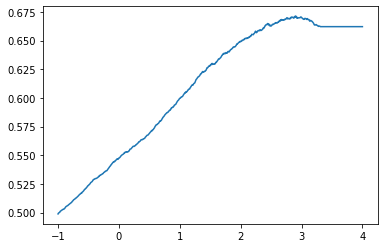

In [ ]:
plt.plot(threshold, res)
plt.show()

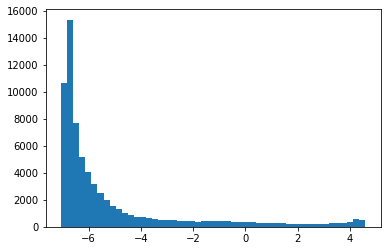

In [ ]:
plt.hist(dev_pred.flatten(), bins = 50)
plt.show()

### inference

In [ ]:
# model = ElectraForSequenceClassification.from_pretrained("kykim/electra-kor-base", num_labels = 1)

Some weights of the model checkpoint at kykim/electra-kor-base were not used when initializing ElectraForSequenceClassification: ['discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense.weight', 'discriminator_predictions.dense.bias']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at kykim/electra-kor-base and are newly initialized: ['classifier.out_proj.weight', 'clas

In [ ]:
# state_dict = torch.load('model/electra_epoch_09_20220930.bin', map_location = 'cpu')
state_dict = torch.load('model/electra_epoch_03_20221005.bin', map_location = 'cpu')
model.load_state_dict(state_dict)
model.to(device)
print(device)

cuda


In [ ]:
model.device

device(type='cuda', index=0)

In [ ]:
# electra

logit_threshold = .2
topk = 1

proba_thre = False

model.eval()
if proba_thre:
    test_pred = np.array([], dtype = np.int32).reshape(-1, len(entity_name_to_id))
else:
    test_pred = np.array([], dtype = np.float32).reshape(-1, len(entity_name_to_id))

for batch in tqdm(test_loader):
    inputs, _ = [b.to(device) for b in batch]
    
    inputs = inputs.reshape(-1, 3, 512)
    input_ids, input_segment, input_masks = inputs[:,0], inputs[:,1], inputs[:,2]
    len_max = max(input_masks.sum(-1))
    input_ids, input_masks, segment_ids = input_ids[:,:len_max], input_masks[:,:len_max], input_segment[:,:len_max]

    with torch.no_grad():
        outputs = model(input_ids, input_masks, segment_ids)
        # b * num cats
        cls_logit = outputs['logits'].reshape(-1, len(entity_name_to_id))
        # lab = labels.float() / labels.sum(1, keepdim = True)
        # dev_losses.append(torch.nn.CrossEntropyLoss()(cls_logit, lab).item())
        # true = labels.detach().cpu().numpy()
            
    if proba_thre:
        pred = (torch.nn.Softmax(-1)(cls_logit) > logit_threshold).int().detach().cpu().numpy()
        if np.where(pred.sum(-1) == 0)[0].size == 0:
            pass
        else:
            replaced_ind = np.where(pred.sum(-1) == 0)[0]
            replace = F.one_hot( torch.topk(cls_logit, topk, -1)[1], len(entity_name_to_id) ).sum(1).detach().cpu().numpy()
            pred[replaced_ind] = replace[replaced_ind]

        test_pred = np.vstack((test_pred, pred))
    else:
        pred = cls_logit.detach().cpu().numpy()
        test_pred = np.vstack((test_pred, pred))
    # pred = F.one_hot( torch.topk(cls_logit, 2, -1)[1], len(entity_name_to_id)//2 ).sum(1).detach().cpu().numpy()
    # pred = (F.one_hot(outputs['logits'].argmax(2), len(entity_name_to_id)+1).sum(1)).detach().cpu()
    # pred = (pred[:, 1::2] + pred[:, 2::2] > 0).int().numpy()

100%|██████████| 133/133 [02:19<00:00,  1.05s/it]


In [ ]:
test_pred_nsp = test_pred.copy()

In [ ]:
print(logit_threshold, topk)
np.unique(test_pred.sum(1), return_counts = True)

0.2 1


(array([1, 2, 3]), array([1308,  730,   89]))

In [ ]:
np.unique((test_pred > 3.36).astype(np.int32).sum(-1), return_counts = True)

(array([0, 1, 2, 3, 4]), array([ 866, 1026,  210,   18,    7]))

In [ ]:
np.unique((test_pred > 3.36).astype(np.int32).sum(-1), return_counts = True)

(array([0, 1, 2, 3, 4]), array([ 866, 1026,  210,   18,    7]))

In [ ]:
lth = 3.3633633633633635
test_pred_ = (test_pred > lth).astype(np.int32)
print(np.unique(test_pred_.sum(-1), return_counts = True))

replaced_ind = np.where(test_pred_.sum(-1) == 0)[0]
argmax = test_pred[replaced_ind].argmax(-1)

zeros = np.zeros((replaced_ind.size, len(entity_id_to_name)))
zeros[np.arange(argmax.size), argmax] = 1

test_pred_[replaced_ind] = zeros

print(int(lth))
test_result = convert(test_pred_, test)

(array([0, 1, 2, 3, 4]), array([ 868, 1025,  211,   16,    7]))
3


In [ ]:
test_result[1230]

{'id': 'nikluge-sa-2022-test-01231',
 'sentence_form': '다만 길이 조절이 되지 않기에 키가 크신 분들은 사용이 다소 불편할 수 있고 헤드가 작아 큰 평수의 경우에는 메인 청소기로 사용하기에는 무리가 있으며 하단에 있는 브러쉬는 따로 분리가 되지 않아서 그 점은 좀 아쉬운 마음입니다.\u200b \u200b\u200b\u200b\u200b',
 'annotation': [['본품#편의성', 'positive']]}

In [ ]:
tt = []
with open('result_20221102_ele_th3_logit.json', 'r') as file:
    for line in file.readlines():
        tt.append(json.loads(line))

In [ ]:
for i, tr in enumerate(test_result):
    if tr != tt[i]:
        print(i)
        print(tr)
        print(tt[i])

In [ ]:

from datetime import date
today = str(date.today()).replace('-','')

import json
th  = int(logit_threshold * 100)
print(today, )

if proba_thre:
    print(th)
    test_result = convert(test_pred, test)
    with open(f'result_{today}_ele_th{th}.json', 'w', encoding = 'utf-8') as f:
        for i in test_result:
            f.write(json.dumps(i, ensure_ascii=False) + '\n')
else:
    lth = 2.9
    test_pred_ = (test_pred > lth).astype(np.int32)
    print(np.unique(test_pred_.sum(-1), return_counts = True))

    replaced_ind = np.where(test_pred_.sum(-1) == 0)[0]
    argmax = test_pred[replaced_ind].argmax(-1)

    zeros = np.zeros((replaced_ind.size, len(entity_id_to_name)))
    zeros[np.arange(argmax.size), argmax] = 1

    test_pred_[replaced_ind] = zeros

    print(int(lth))
    test_result = convert(test_pred_, test)
    with open(f'result_{today}_ele_th{int(lth)}_logit.json', 'w', encoding = 'utf-8') as f:
        for i in test_result:
            f.write(json.dumps(i, ensure_ascii=False) + '\n')

20221103
(array([0, 1, 2, 3, 4]), array([ 859, 1006,  193,   57,   12]))
2


In [ ]:
print(np.unique(test_pred_.sum(-1), return_counts = True))

(array([1, 2, 3, 4]), array([1865,  193,   57,   12]))


In [ ]:
tt = []
with open('submission/result_20221012_ele_th10.json', 'r') as file:
    tt = json.load(file)


In [ ]:
diff = 0
for i, t in enumerate(tt):
    if t != test_result[i]:
        diff+=1
print(diff)

0


In [ ]:
len(tt)

2127

In [ ]:
tt = []
with open('submission/result_20221012_ele_th10.json', 'r') as file:
    for line in file.readlines():
        tt.append(json.loads(line))

ttt = []
with open('result_20221026_ele_th10_copy.json', 'r') as file:
    for line in file.readlines():
        ttt.append(json.loads(line))

## ASC

### run

In [ ]:
model_asc.to(device)
print(device)

cuda


In [ ]:
best_score = 0
global_step = 0
total_loss = 0

for ep in range(int(num_train_epochs)):
    model_asc.train()
    pbar = tqdm(train_loader)
    for step, batch in enumerate(pbar):
        inputs, labels = [b.to(device) for b in batch]
        
        input_ids, input_segment, input_masks = inputs[:,0], inputs[:,1], inputs[:,2]
        len_max = max(input_masks.sum(-1))
        input_ids, input_masks, segment_ids = input_ids[:,:len_max], input_masks[:,:len_max], input_segment[:,:len_max]

        outputs = model_asc(input_ids, input_masks, segment_ids)

        cls_logit = outputs['logits']

        loss_fct = torch.nn.CrossEntropyLoss()
        loss = loss_fct(cls_logit, labels)

        if gradient_accumulation_steps > 1:
            loss = loss / gradient_accumulation_steps
        total_loss += loss.item()

        loss.backward()
        pbar.update(1)

        lr = optimizer.param_groups[0]['lr']

        if (step + 1) % 10 == 0:
            #pbar.set_description(desc=f'loss:{np.mean(total_loss)}')
            pbar.set_description(desc='  loss : {}, lr : {}'.format(total_loss/10, round(lr, 6)))
            total_loss = 0
        if (step + 1) % gradient_accumulation_steps == 0:
            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad()
            global_step += 1

    # gamma *= 0.7
    time.sleep(0.1)

    model_asc.eval()
    dev_pred = np.array([])
    dev_true = np.array([])
    dev_losses = []
    # dev_step = 0
    for batch in dev_loader:
        inputs, labels = [b.to(device) for b in batch]
        
        input_ids, input_segment, input_masks = inputs[:,0], inputs[:,1], inputs[:,2]
        len_max = max(input_masks.sum(-1))
        input_ids, input_masks, segment_ids = input_ids[:,:len_max], input_masks[:,:len_max], input_segment[:,:len_max]

        with torch.no_grad():
            outputs = model_asc(input_ids, input_masks, segment_ids)
            # b * num cats
            cls_logit = outputs['logits']
            dev_losses.append(torch.nn.CrossEntropyLoss()(cls_logit, labels).item())
            
            true = labels.unsqueeze(0).detach().cpu().numpy()
               
            pred = cls_logit.argmax(1).unsqueeze(0).detach().cpu().numpy()
            # pred = F.one_hot( torch.topk(cls_logit, 2, -1)[1], len(entity_name_to_id)//2 ).sum(1).detach().cpu().numpy()
            # pred = (F.one_hot(outputs['logits'].argmax(2), len(entity_name_to_id)+1).sum(1)).detach().cpu()
            # pred = (pred[:, 1::2] + pred[:, 2::2] > 0).int().numpy()

            dev_pred = np.append(dev_pred, pred)
            dev_true = np.append(dev_true, true)
            
    # score
    # score = evaluation_f1(val, convert(dev_pred.astype(int)))['category extraction result']['F1']
    score = f1_score(dev_true.astype(int), dev_pred.astype(int), average = 'macro')
    
    print('epoch : {}, dev score : {}, loss : {}'.format(ep, score, np.mean(dev_losses)), end = '\t')
  
    if score > best_score:
        print('-----------best----------')
        best_score = score
        torch.save(model_asc.state_dict(), 
                   re.sub(r'(?<=electra).{0,}(?=\.)', f'_epoch_{str(ep).zfill(2)}_{today}', model_save_path)
                   )
    else:
        print()
    time.sleep(0.1)



In [ ]:
f1_score(dev_true, dev_pred, average = 'macro')

0.32883475971033577

In [ ]:
(dev_true == dev_pred).sum() / dev_true.size

0.9184800259824618

In [ ]:
f1_score(dev_true, dev_pred, average = 'micro')

0.9184800259824618

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(dev_true, dev_pred)

array([[2787,    9,  201],
       [   2,   20,    6],
       [  27,    6,   21]])

### inference

In [ ]:
model_asc = ElectraForSequenceClassification.from_pretrained("kykim/electra-kor-base", 
                                                             num_labels = len(polarity_id_to_name))

Some weights of the model checkpoint at kykim/electra-kor-base were not used when initializing ElectraForSequenceClassification: ['discriminator_predictions.dense.weight', 'discriminator_predictions.dense.bias', 'discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense_prediction.weight']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at kykim/electra-kor-base and are newly initialized: ['classifier.dense.weight', 'classif

In [ ]:
state_dict = torch.load('model/electra_epoch_00_20221001.bin', map_location = 'cpu')
# state_dict = torch.load('model/electra_epoch_07_20221003.bin', map_location = 'cpu')
model_asc.load_state_dict(state_dict)
model_asc.to(device)
print(device)

cuda


In [ ]:
# all positive
evaluation_f1(val, test_result)

{'category extraction result': {'Precision': 0.7014100082941664,
  'Recall': 0.823968821045794,
  'F1': 0.7577658303464755},
 'entire pipeline result': {'Precision': 0.6819933920704846,
  'Recall': 0.8044819746670997,
  'F1': 0.7381910296528089}}

In [ ]:
# model_asc trained by weighted random sampler
evaluation_f1(val, test_result)

{'category extraction result': {'Precision': 0.7014100082941664,
  'Recall': 0.823968821045794,
  'F1': 0.7577658303464755},
 'entire pipeline result': {'Precision': 0.6487523992322457,
  'Recall': 0.7684313088665151,
  'F1': 0.7035385072851621}}

In [ ]:
# model_asc trained by random sampler
evaluation_f1(val, test_result)

{'category extraction result': {'Precision': 0.7014100082941664,
  'Recall': 0.823968821045794,
  'F1': 0.7577658303464755},
 'entire pipeline result': {'Precision': 0.6819933920704846,
  'Recall': 0.8044819746670997,
  'F1': 0.7381910296528089}}

In [ ]:
def get_testset(batch, train, max_len = 512):
    train_docs = [t['sentence_form'] for t in train]
    docs = [train_docs[b] for b in batch]
    train_batch = [train[b] for b in batch]

    result = torch.LongTensor([]).reshape(-1, 3, max_len)
    labels = []
    
    for idx, t in enumerate(train_batch):
        polar = []
        entity = []
        for a in t['annotation']:
            entity.append(a[0])
            polar.append(a[1])
        
        sents = [t['sentence_form']] * len(entity)
        tokenized = tokenizer(sents, entity, padding='max_length', truncation=True, max_length=max_len)
        tokenized = torch.LongTensor([v for k, v in tokenized.items()]).transpose(0, 1 )
        result = torch.vstack((result, tokenized))
        labels += [ polarity_name_to_id[p] for p in polar]

    labels = torch.tensor(labels, dtype=torch.long)
    return result, labels

In [ ]:
# for validation

batch_size = 1
test_range_asc = torch.arange(len(val))
test_ds_asc = TensorDataset(test_range_asc)
test_loader_asc = DataLoader(test_ds_asc, sampler=SequentialSampler(test_ds_asc), batch_size=batch_size)

In [ ]:
batch_size = 1
test_range_asc = torch.arange(len(test))
test_ds_asc = TensorDataset(test_range_asc)
test_loader_asc = DataLoader(test_ds_asc, sampler=SequentialSampler(test_ds_asc), batch_size=batch_size)

In [ ]:
test_result_copy = deepcopy(test_result)

In [ ]:
model_asc.eval()
test_pred_ids = np.array([])

for batch in tqdm(test_loader_asc):
    inputs, _ = get_testset(batch[0], test_result, )
    inputs = inputs.to(device)
    
    input_ids, input_segment, input_masks = inputs[:,0], inputs[:,1], inputs[:,2]
    len_max = max(input_masks.sum(-1))
    input_ids, input_masks, segment_ids = input_ids[:,:len_max], input_masks[:,:len_max], input_segment[:,:len_max]

    with torch.no_grad():
        outputs = model_asc(input_ids, input_masks, segment_ids)
        # b * num cats
        cls_logit = outputs['logits']
        # dev_losses.append(torch.nn.CrossEntropyLoss()(cls_logit, labels).item())
        
        # true = labels.unsqueeze(0).detach().cpu().numpy()
            
        pred = cls_logit.argmax(1).detach().cpu().numpy()
        # pred = F.one_hot( torch.topk(cls_logit, 2, -1)[1], len(entity_name_to_id)//2 ).sum(1).detach().cpu().numpy()
        # pred = (F.one_hot(outputs['logits'].argmax(2), len(entity_name_to_id)+1).sum(1)).detach().cpu()
        # pred = (pred[:, 1::2] + pred[:, 2::2] > 0).int().numpy()
    test_pred_ids = np.append(test_pred_ids, pred)
    for ip, pp in enumerate(pred):
        test_result[batch[0].item()]['annotation'][ip][-1] = polarity_id_to_name[pp]

100%|██████████| 2794/2794 [01:35<00:00, 29.34it/s]


In [ ]:
test_result[12]

{'id': 'nikluge-sa-2022-test-00013',
 'sentence_form': '하또무기 스킨도 자극이 없고 피부 진정되는 느낌이어서이것도 비슷한 성분일 것 같아서 믿고 씁니당~',
 'annotation': [['본품#품질', 'positive']]}

In [ ]:
test_result[12]

{'id': 'nikluge-sa-2022-test-00013',
 'sentence_form': '하또무기 스킨도 자극이 없고 피부 진정되는 느낌이어서이것도 비슷한 성분일 것 같아서 믿고 씁니당~',
 'annotation': [['본품#품질', 'positive']]}

In [ ]:
from collections import Counter 
cc = Counter()

for tt in test_result:
    for a in tt['annotation']:
        cc[a[-1]] += 1

cc

Counter({'positive': 2401})

In [ ]:
import json
from datetime import date
today = str(date.today()).replace('-','')
print(today)

with open(f'result_{today}.json', 'w', encoding = 'utf-8') as f:
    json.dump(test_result, f, ensure_ascii=False)

20221006
